## Plot squared Pearson R$^2$ and Nash-Sutcliffe efficiency NSE


Both measures (R2) and NSE are indications of how well the observed data fits the simulated one. 

$$NSE= 1-  \frac{\sum \limits_{i=1}^{n} (Y^{obs}_i -Y^{sim}_i )^2}{\sum \limits_{i=1}^{n}(Y^{obs}_i -Y^{mean}_i )^2}  $$

In [222]:
#Import 
%matplotlib notebook
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from functions import mapplot
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import MultiPoint, Point
from shapely import ops
from joypy import joyplot
import rasterio
from rasterio.plot import show

In [2]:
#Load error files
folder = Path("D:/Data/students/mariana/codes/GW_forecasting_ML/Results_seq12/")
df = pd.concat([
    pd.read_csv(fname)
    for fname in folder.glob("summary_CNN_*.txt")
])

In [3]:
#Load error files
folder2 = Path("D:/Data/students/mariana/codes/GW_forecasting_ML/wihtoutRH/")
df_norh = pd.concat([
    pd.read_csv(fname)
    for fname in folder2.glob("summary_CNN_*.txt")
])

In [4]:
len(df), len(df_norh)

(355, 163)

In [60]:
df.loc[df.NSE<0, 'NSE'] = 0
df_norh.loc[df_norh.NSE<0, 'NSE'] = 0

In [7]:
#List of series with Jumps
l=['9610863','40000231','9610021','9700058','9700078','9700214','9700233','9700242','9700251','9700259','9700260','9700267',
 '9700294','40501211','40501280','40501871','40504001','40504710','40504730','40507561','40510160','40510360','40510490',
 '40510500','100000902','200000532','200001392','400060461']
ln=[int(n) for n in l]

In [8]:
#Remove the wells that have to be re-model without the records before 1990
dfc=df.reset_index()
dfd=dfc.drop(dfc.loc[dfc.wellid.isin(ln)].index)

In [9]:
df['NSE_RH']=df['NSE']
df['r2_RH']=df['r2']

In [61]:
dfcomb=pd.concat([df.reset_index().NSE_RH,df.reset_index().r2_RH, df_norh.reset_index().NSE, df_norh.reset_index().r2], axis=1)

<IPython.core.display.Javascript object>


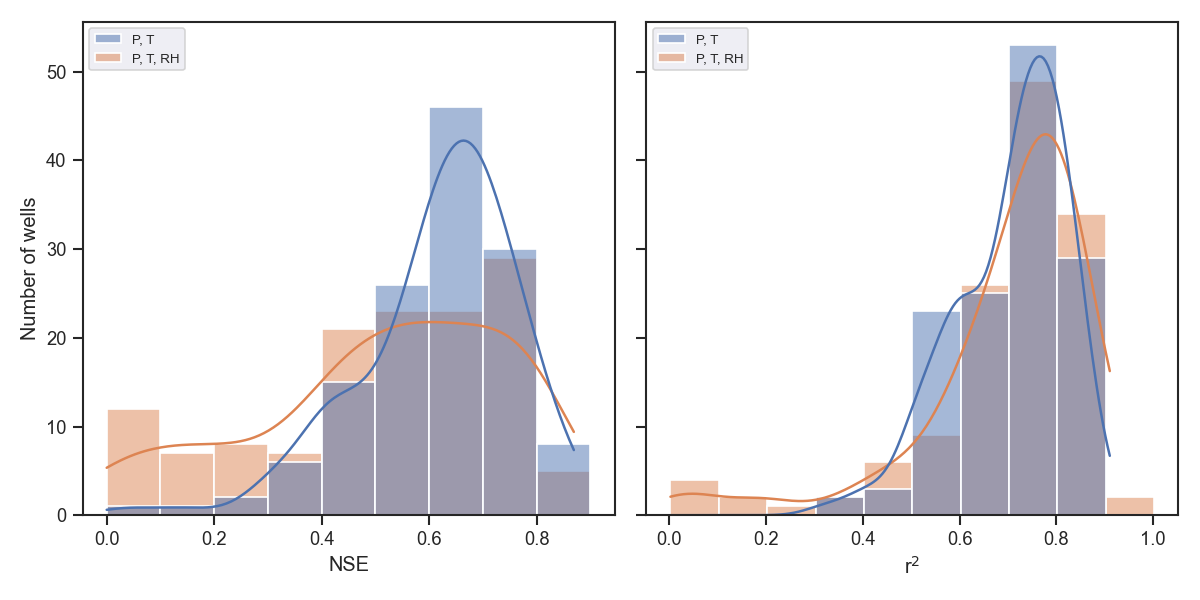

In [62]:
lim=len(df_norh)-len(l)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5), sharey=True)
sns.set_theme(style="dark", palette="deep")
#sns.histplot(data=df.NSE[:len(df_norh)],kde=True)
sp= sns.histplot(data=dfcomb[['NSE','NSE_RH']][:lim],kde=True,binwidth=0.1, ax=ax1)

ax1.set_xlabel('NSE')
ax1.set_ylabel(r'Number of wells')
legendax1 = ax1.get_legend()
handlesax1 = legendax1.legendHandles
legendax1.remove()
ax1.legend(handlesax1, ['P, T', 'P, T, RH'],fontsize=3,prop={'size': 8}, loc=2)

sp2=sns.histplot(data=dfcomb[['r2','r2_RH']][:lim],kde=True,binwidth=0.1, ax=ax2)
ax2.set_xlabel('r$^2$')
ax2.set_ylabel(r'Number of wells')
legendax2 = ax2.get_legend( )
handlesax2 = legendax2.legendHandles
legendax2.remove()
ax2.legend(handlesax2,['P, T', 'P, T, RH'],prop={'size': 8}, loc=2)
plt.tight_layout() 

<IPython.core.display.Javascript object>


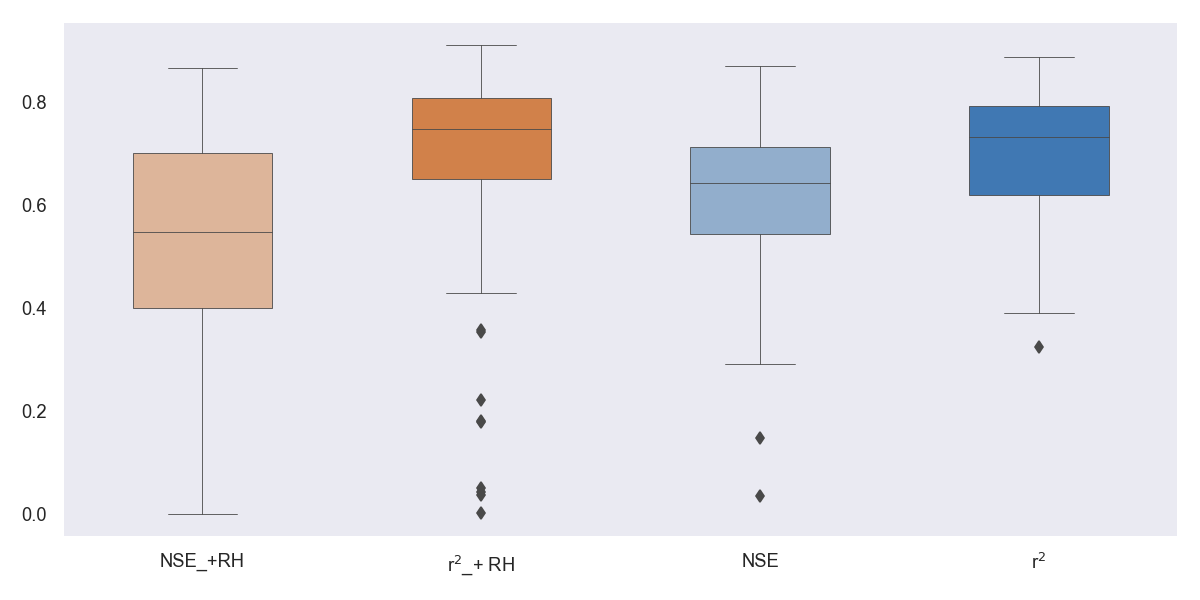

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set_theme(style="darkgrid")
colors = ['#E8B38F', '#e77d34', '#88aed6','#2d77c6']
bx=sns.boxplot(ax=ax,data=dfcomb[:lim],palette=colors,linewidth=0.5,width=0.5)
ax.set_xticklabels(["NSE_+RH","r$^2$_+ RH","NSE","r$^2$"])
plt.tight_layout()

<IPython.core.display.Javascript object>


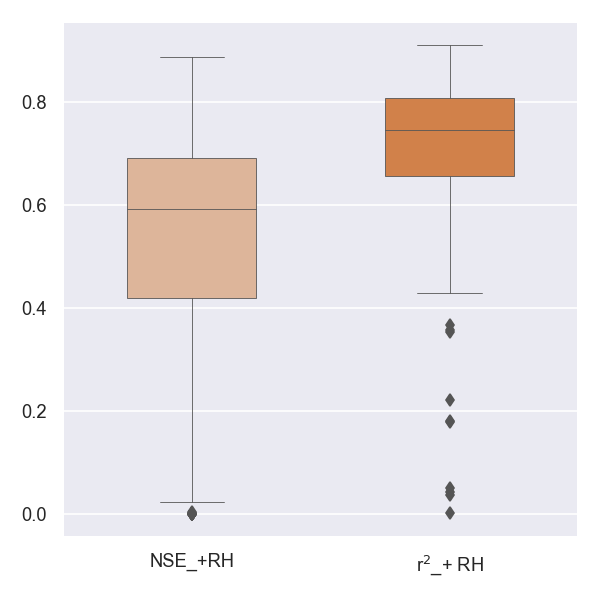

In [64]:
fig, ax = plt.subplots(figsize=(5,5))
sns.set_theme(style="darkgrid")
colors = ['#E8B38F', '#e77d34']
bx=sns.boxplot(ax=ax,data=dfcomb[['NSE_RH','r2_RH']],palette=colors,linewidth=0.5,width=0.5)
ax.set_xticklabels(["NSE_+RH","r$^2$_+ RH"])
plt.tight_layout()

## Geospatial analyses

This section is to check the spatial relations between the model performance results and the spatial features such as landcover,  and distance to rivers

In [68]:
#this lines takes a while for running due to the size of the landuse shapefile

#Load shapefiles
gw_sel=gpd.read_file("D:/Data/students/mariana/data/SHP/GWF2.shp")

#LS GIS information OSM
waterbodies=gpd.read_file("D:/Data/students/mariana/data/SHP/waterbodiesND.shp")
waterways=gpd.read_file("D:/Data/students/mariana/data/SHP/waterwaysND.shp")

#Administrative boundaries
germany_states = gpd.read_file("D:/Data/students/mariana/data/SHP/DEU_adm1.shp")
ND=germany_states[germany_states.NAME_1== "Niedersachsen"]

In [69]:
#BGR hydrogeology map 1:250k clipped for Lower Saxony
hydrogeologischeND=gpd.read_file("D:/Data/students/mariana/data/SHP/hydrogeologischeND.shp")

#LS GIS information OSM
citiesND=gpd.read_file("D:/Data/students/mariana/data/SHP/citiesND.shp")
landuse=gpd.read_file("D:/Data/students/mariana/data/SHP/LS/gis_osm_landuse_a_free_1.shp")
places=gpd.read_file("D:/Data/students/mariana/data/SHP/LS/gis_osm_places_a_free_1.shp")

First, the model performance should be associated with the shapefile information

In [101]:
#Create a column to store the accuracy of the models- this is created in the shapefile that has the wells ID
gw_sel[['NSE','r2','NSE_2','r2_2']]=np.nan
for i in range(len(df)):
    index=gw_sel.loc[gw_sel.MEST_ID==df.wellid.values[i]].index[0]
    gw_sel.at[index, 'NSE'] = df.NSE.values[i]
    gw_sel.at[index, 'r2'] = df.r2.values[i]
    if i < len(df_norh):
        gw_sel.at[index, 'NSE_2'] = df_norh.NSE.values[i]
        gw_sel.at[index, 'r2_2'] = df_norh.r2.values[i]
        
    

In [102]:
c=gw_sel.r2.copy()
c.dropna(inplace=True)
c.describe()

count    355.000000
mean       0.710503
std        0.144105
min        0.001982
25%        0.655839
50%        0.746111
75%        0.807481
max        0.910183
Name: r2, dtype: float64

### Plot NSE and R2

In [83]:
#Project shapefiles for mapping
proj_coor=4647
gw_sel=gw_sel.to_crs(epsg=proj_coor)
waterbodies=waterbodies.to_crs(epsg=proj_coor)
waterways=waterways.to_crs(epsg=proj_coor)

hydrogeo=hydrogeologischeND.to_crs(epsg=proj_coor)
cities=citiesND.to_crs(epsg=proj_coor)
land_use=landuse.to_crs(epsg=proj_coor)
germany_states=germany_states.to_crs(epsg=proj_coor)
ND=ND.to_crs(epsg=proj_coor)


In [21]:
import matplotlib.colors as colors

<IPython.core.display.Javascript object>


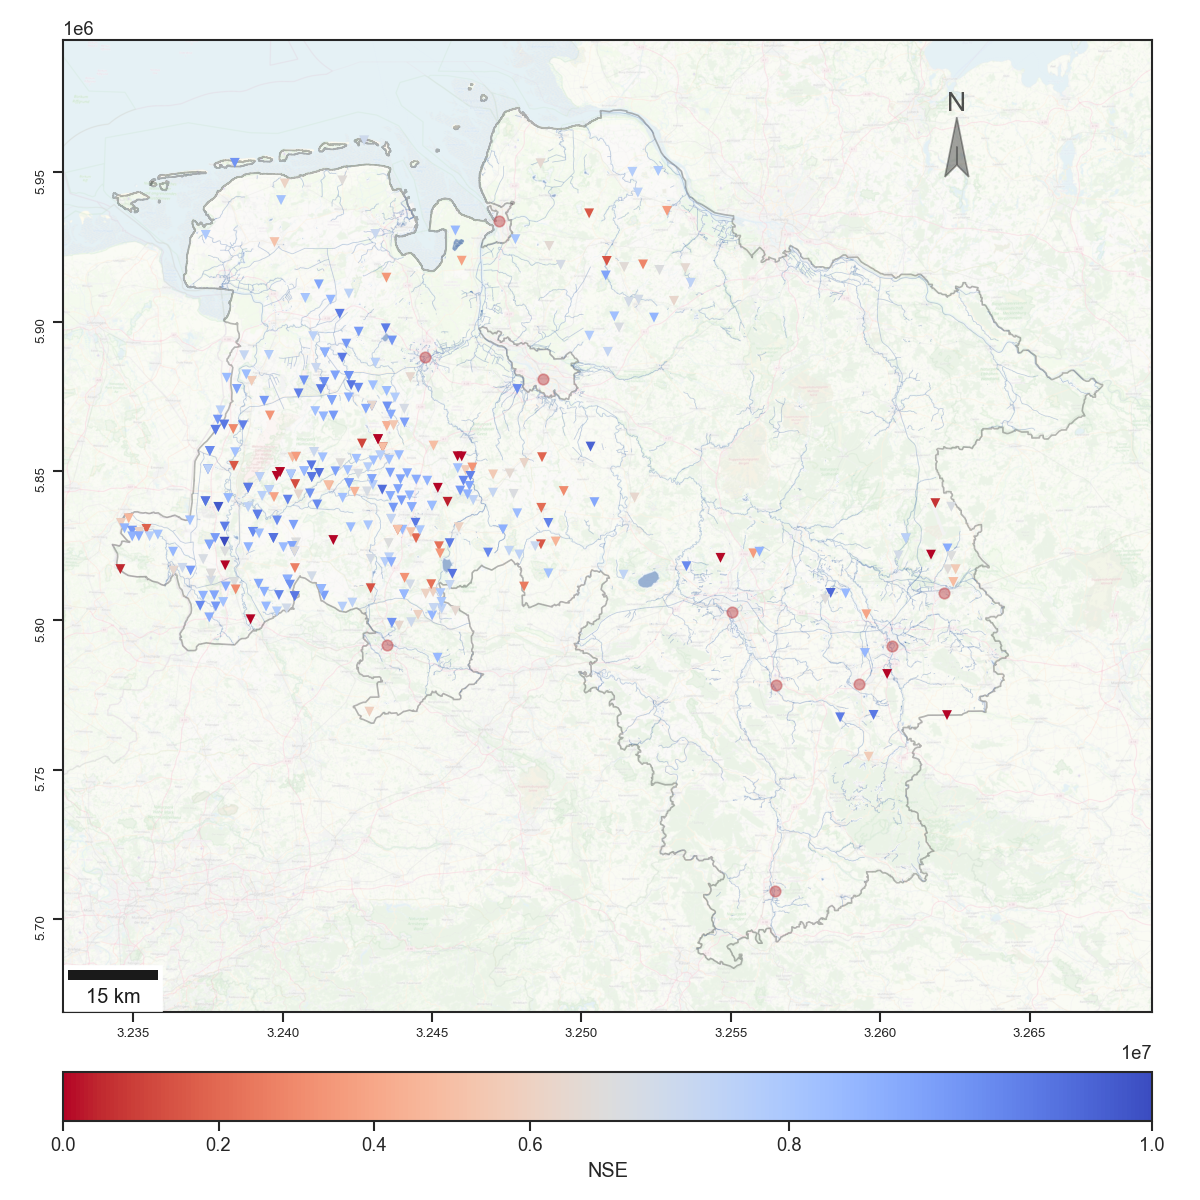

In [23]:
sns.set_theme(style="ticks")
column='NSE'
bound=germany_states.to_crs(gw_sel.crs.to_string()) 
gw=gw_sel.plot(figsize=(10, 10),column=column, markersize=35,
               marker="v", facecolor="None",cmap="coolwarm_r",edgecolor="grey",linewidth=0.01, zorder=3)
wb=waterbodies.plot( ax=gw, alpha=0.5, color='b', linewidth=0.8, zorder=1)
ww=waterways.plot( ax=gw, alpha=0.3, color='b', linewidth=.5,zorder=2)
#gdff=gdf.plot( ax=gw, alpha=0.5, color='r',markersize=12,zorder=2)
cit=cities.plot( ax=gw, alpha=0.5, color='r',markersize=40,zorder=2)
NS=ND.boundary.plot( ax=gw, alpha=0.3, edgecolor='k', linewidth=1, zorder=1)

#Colorbar 
sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=colors.TwoSlopeNorm(vmin=0, vcenter=0.7, vmax=1))
#sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=plt.Normalize(vmin=gw_sel[column].min(), 
#                                                                       vmax=gw_sel[column].max()))

fig=gw.get_figure()
divider = make_axes_locatable(gw)
cax = divider.append_axes('bottom', size='5%', pad=0.5)
cbar = fig.colorbar(sm,orientation="horizontal",fraction=0.05,cax=cax)
cbar.ax.set_xlabel(column)


#for x, y, label in zip(gw_sel.geometry.x[:len(df)], gw_sel.geometry.y[:len(df)], gw_sel.MEST_ID[:len(df)]):
#    gw.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)



#scalebar
scalebar = ScaleBar(0.5, "m", dimension="si-length", length_fraction=0.10, location="lower left")
gw.add_artist(scalebar)
gw.tick_params(axis='y', which='major', labelsize=8, rotation=90)
gw.tick_params(axis='x', which='major', labelsize=8, rotation=0)
startx, endx = gw.get_xlim()
starty, endy = gw.get_ylim()

#North arrow
arrx=endx- endx*0.002
arry=endy-endy*0.0040
gw.text(x=arrx-arrx*0.0001, y=arry, s='N', fontsize=16,alpha=0.8)
gw.arrow(arrx, arry-arry*0.002, 0, 10000, length_includes_head=True,
          head_width=8000, head_length=20000, overhang=.2, ec="k",facecolor='k', alpha=0.4)

#Basemap
#cx.providers.OpenStreetMap.Mapnik
cx.add_basemap(ax=NS,  crs=ND.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik,alpha=0.3,zoom=10,attribution=False,zorder=0)
plt.tight_layout()       

## Geospatial relations

### Relation with the hydrogeological maps

Information in the hydrogeological map

HE_B Hydrogeologic unit, abbreviation 01K (1-4)A \
HE_B_BEZ Hydrogeologic unit, designation Quaternary (unclassified) \
GA Rock type, abbreviation S \
__GA_bez__ Rock type, designation Sedimentary \
VF consolidation, abbreviation L \
__VF_bez__ consolidation, designation unconsolidated rock -- Lockergestein (loose rock), Festgestein (hard rock) \
HA Cavity type, abbreviation P \
__HA_bez__ Cavity type, designation pores \
GC Geochemical rock type, abbreviation s \
__GC_bez__ Geochemical rock type, designation siliceous \
KF Permeability (m/s), abbreviation 11 \
__KF_bez__ Permeability (m/s), designation highly variable \
LChar Conductor character, abbreviation GWG/GWL \
__LChar_bez__ Conductor character, designation groundwater conductor/groundwater conductor \
__Litho__ Lithology Gravel, sand, silt \
Strat1 Stratigraphy (General) Quaternary \
Start2 Stratigraphy (Detail) Quaternary 

In [214]:
#Intersect map with the well locations
hgint=gpd.overlay(gw_sel, hydrogeo, how='intersection')

All wells are located in sedimentary rock-type

In [226]:
hgintcl.Litho.values

array([239, 227,   6,   4,   2,   2,   2,   2,   2,   2,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1], dtype=int64)

<IPython.core.display.Javascript object>


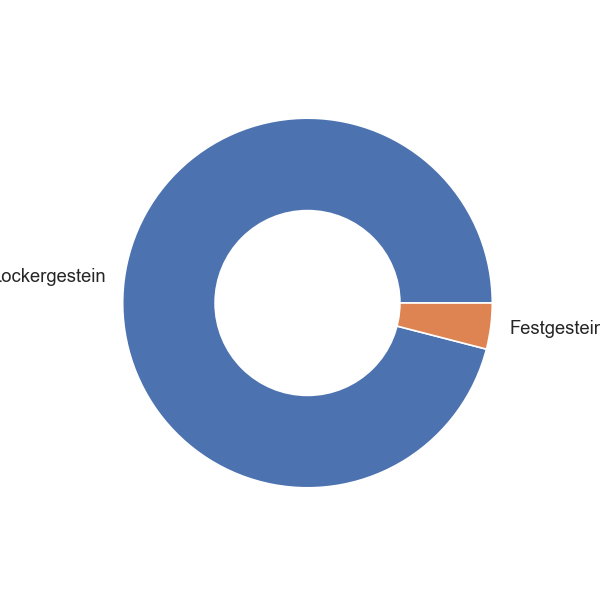

<IPython.core.display.Javascript object>


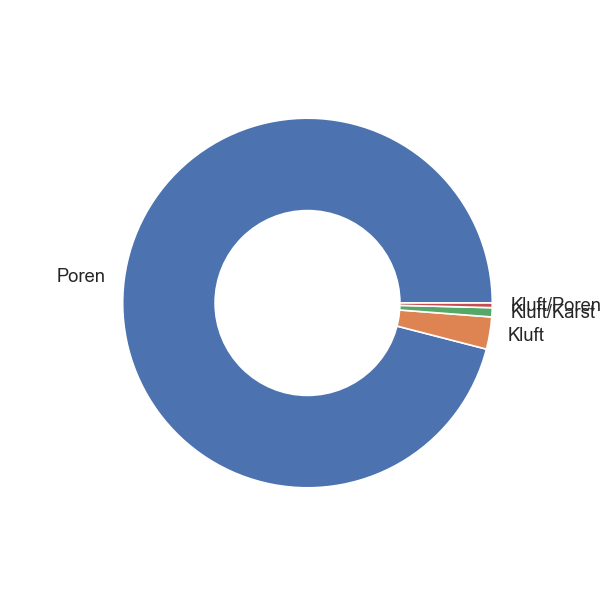

<IPython.core.display.Javascript object>


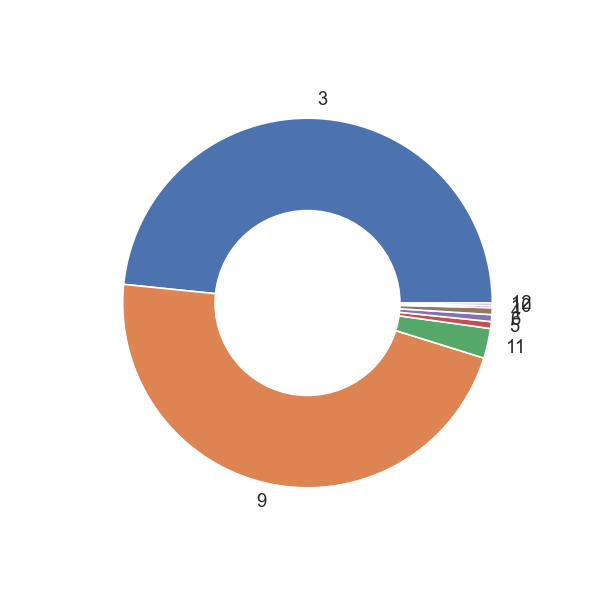

<IPython.core.display.Javascript object>


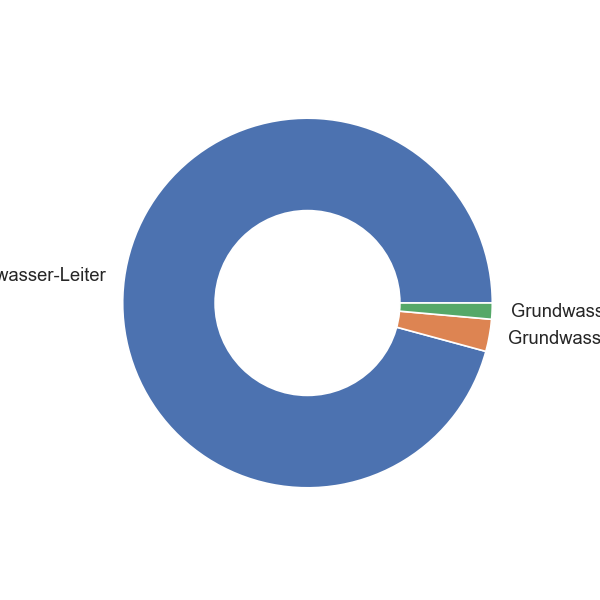

<IPython.core.display.Javascript object>


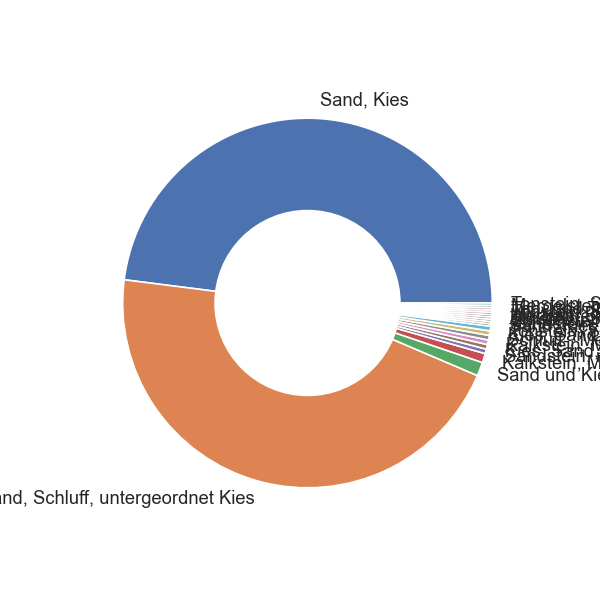

In [233]:
column=['VF_bez','HA_bez','kf','LChar_bez','Litho']
for cl in column:
    hgintcl=pd.DataFrame(hgint[cl].value_counts())
    order=hgintcl.index
    plt.figure(figsize=(5,5))
    my_circle = plt.Circle( (0,0), 0.5, color='white')
    plt.pie(hgintcl[cl].values, labels=hgintcl[cl].index)
    p = plt.gcf()
    p.gca().add_artist(my_circle)

<IPython.core.display.Javascript object>


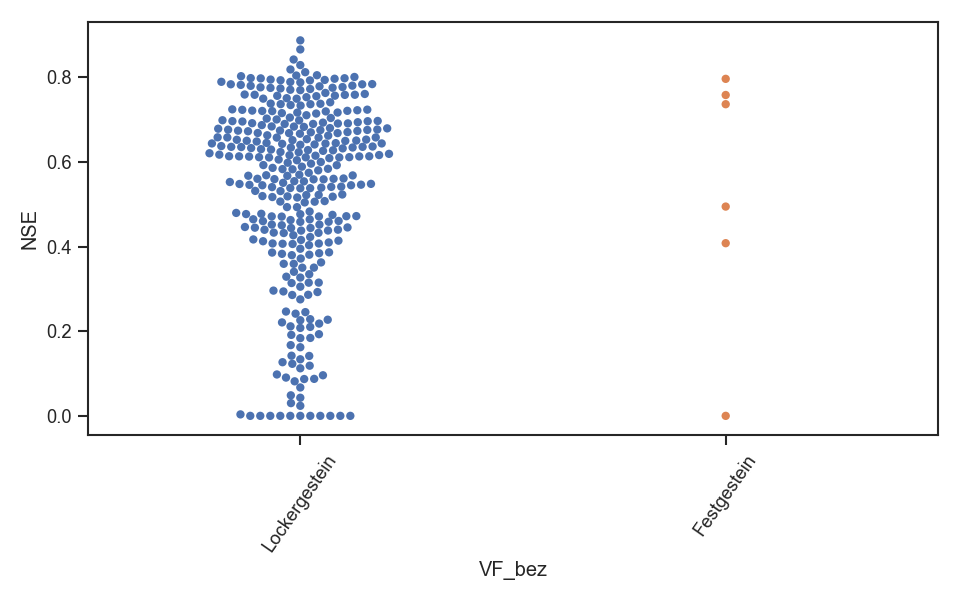

<IPython.core.display.Javascript object>


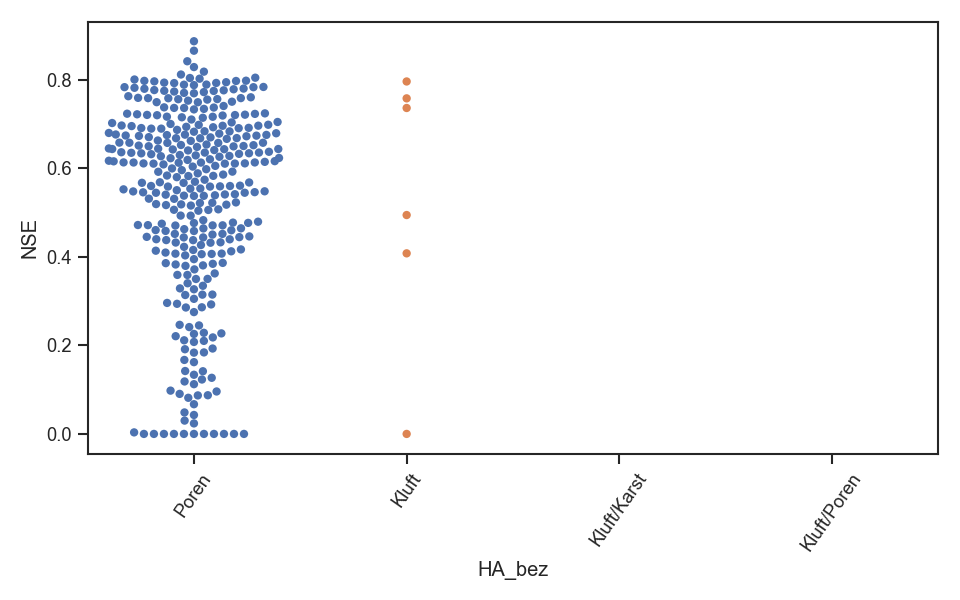

<IPython.core.display.Javascript object>


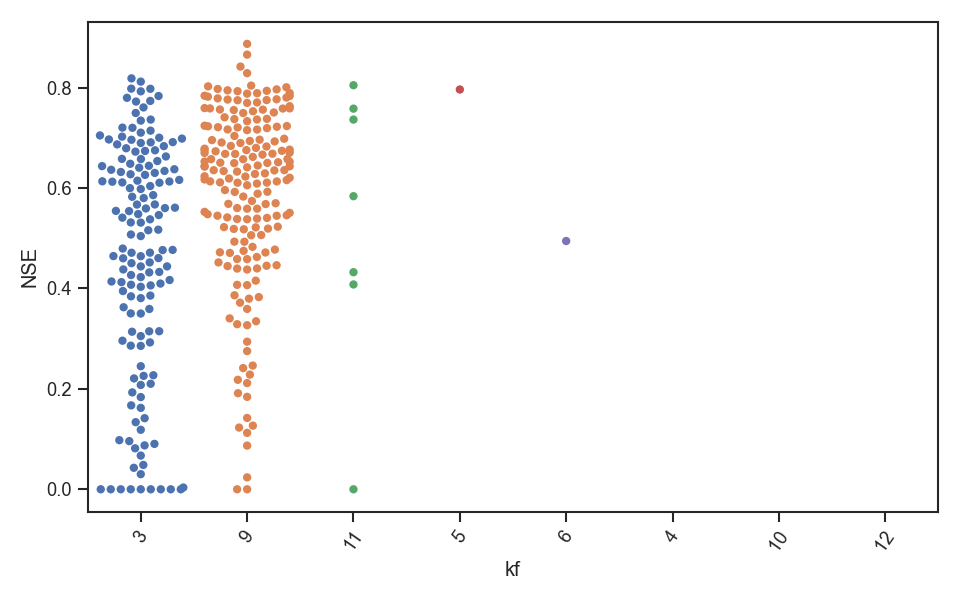

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


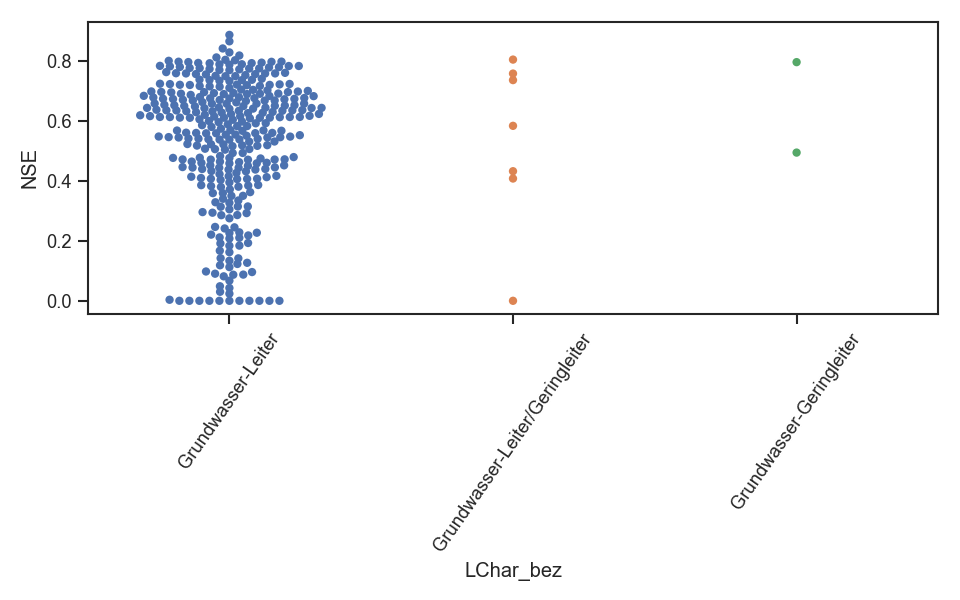

<IPython.core.display.Javascript object>


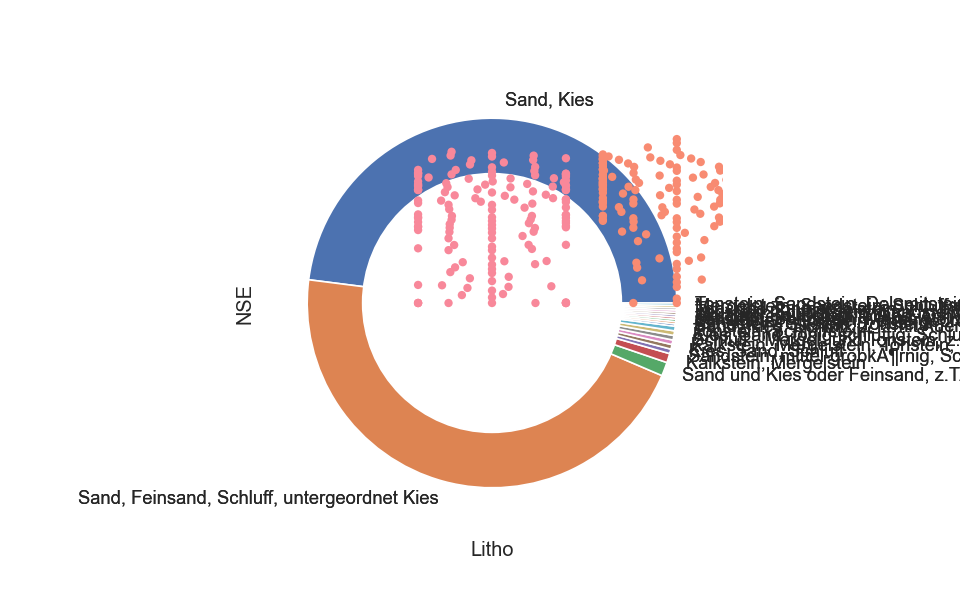

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\GomezOspina.M\AppData\Local\Temp\7\ipykernel_24396\1588636379.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [215]:
column=['VF_bez','HA_bez','kf','LChar_bez','Litho']
for cl in column:
    hgintcl=pd.DataFrame(hgint[cl].value_counts())
    order=hgintcl.index
    fig, ax = plt.subplots(figsize=(8,5))
    cp=sns.swarmplot(ax=ax,x=cl, y="NSE",order=order, data=hgint)
    cp.set_xticklabels(order, rotation=55)
    ax.set_xlabel(cl)
    ax.set_ylabel('NSE')
    plt.tight_layout() 

### Intersection with the OSM data 

The OpenStreetMap data for the lower Saxony can be obtained in the following link: https://download.geofabrik.de/europe/germany/niedersachsen.html

In [103]:
r=gpd.overlay(gw_sel, land_use, how='intersection')

In [66]:
cl=pd.DataFrame(r.fclass.value_counts())
cl['names']=cl.index
cl.names.replace('nature_reserve','Reserve', inplace=True)
order=cl.names[:]

In [67]:
rdrop=r.iloc[r.index!=107]
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x="fclass", y="NSE",order=order, data=rdrop)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel('Landuse')
ax.set_ylabel('NSE')
plt.tight_layout() 

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x="fclass", y="r2",order=order, data=rdrop)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel('Landuse')
ax.set_ylabel('r$^2$')
plt.tight_layout() 

<IPython.core.display.Javascript object>

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [47]:
rdropsel=rdrop.loc[rdrop['fclass'].isin(['forest','farmland','residential','meadow','grass','farmyard'])]

<IPython.core.display.Javascript object>


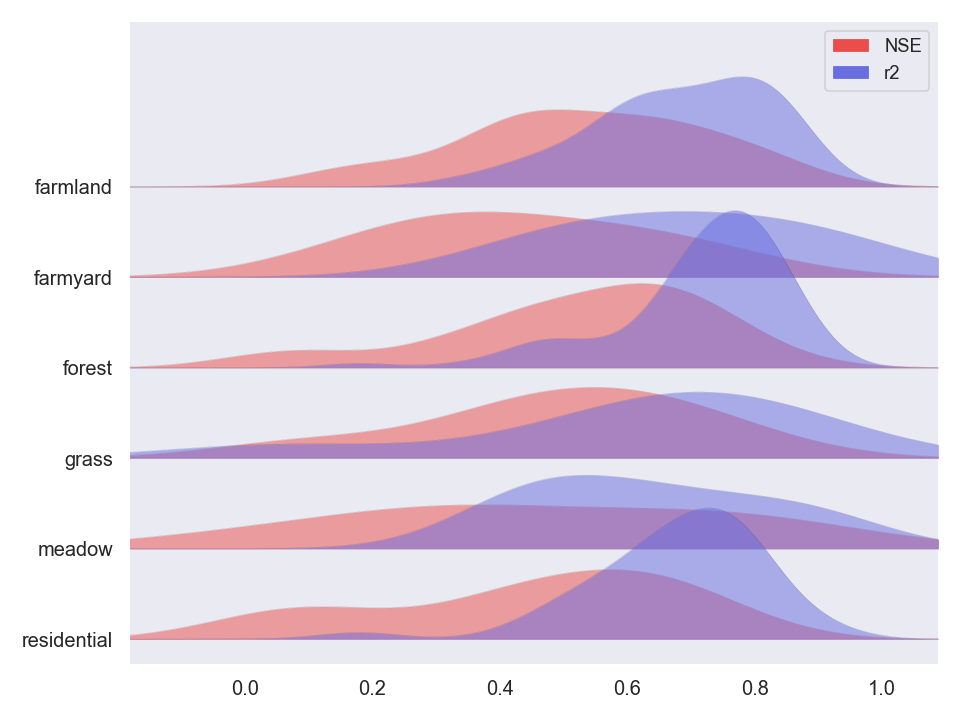

(<Figure size 800x600 with 7 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [78]:
joyplot(
    data=rdropsel[['NSE','r2', 'fclass']], 
    by='fclass',
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

### Intersection with Corine-land cover data

Check the relation witht the CORINE Land Cover (CLC) inventory for 2019. 
Downloaded from https://land.copernicus.eu/pan-european/corine-land-cover

It consists of 44 classes described here https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html

'112'--> __Discontinuous urban fabric (Artificial Surfaces )__\
'121'--> Industrial or commercial units (Artificial Surfaces )\
'124'--> Airports (Artificial Surfaces )\
'142'--> Sport and leisure facilities (Artificial Surfaces )\
'211'--> __Non-irrigated arable land (Agricultural areas )__\
'231'--> __Pastures (Agricultural areas )__\
'311'--> Broad-leaved forest (Forest and seminatural areas )\
'312'--> __Coniferous forest  (Forest and seminatural areas )__\
'313'--> Mixed forest (Forest and seminatural areas )\
'322'--> Moors and heathland  (Forest and seminatural areas )\
'412'--> Peatbogs (Wetlands)\
'512'--> Water bodies 

note: the bold categories are the most relevant 

In [104]:
#Load the corine land cover 2008 
clc=gpd.read_file("D:/Data/students/mariana/data/SHP/clc2018/clc2018_LSr.shp")
clcs=clc.to_crs(epsg=proj_coor)

In [181]:
#Intersect the layer and the wells ID
clcsint=gpd.overlay(gw_sel, clcs, how='intersection')

In [183]:
dic_cat={'112':'Discontinuous urban fabric',
'121': 'Industrial or commercial units ',
'124' : 'Airports',
'142': 'Sport and leisure facilities',
'211': 'Non-irrigated arable land' ,
'231': 'Pastures',
'311' : 'Broad-leaved forest', 
'312': 'Coniferous forest' , 
'313': 'Mixed forest' ,
'322': 'Moors and heathland' , 
'412': 'Peatbogs' ,
'512':' Water bodies' }

In [184]:
clcsint['name']=clcsint['Code_18'].map(dic_cat)

In [186]:
cl='name'
clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
order=clcsintcl.index

In [187]:
Lcat=clcsintcl.loc[clcsintcl.name<8].index
ind=clcsint.loc[clcsint['name'].isin(Lcat)].name.index
clcsint.loc[ind, 'name'] = "others"

<IPython.core.display.Javascript object>


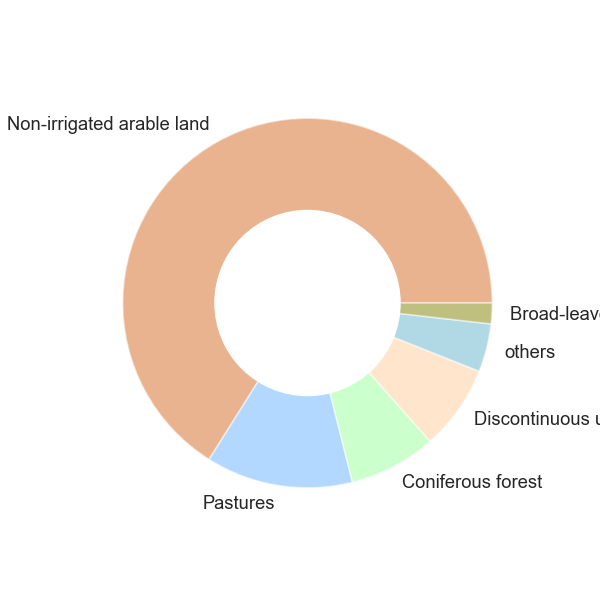

In [208]:
cl='name'
clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
order=clcsintcl.index
plt.figure(figsize=(5,5))
my_circle = plt.Circle( (0,0), 0.5, color='white')
colors = ['chocolate','#66b3ff','#99ff99','#ffcc99','c','olive']
plt.pie(clcsintcl[cl].values, labels=clcsintcl[cl].index, colors=colors,wedgeprops={'alpha':0.5})
p = plt.gcf()
p.gca().add_artist(my_circle)

In [118]:
col='Code_18'
clcclass=pd.DataFrame(clcsint[col].value_counts())
order=clcclass.index
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x=col, y="NSE",order=order, data=clcsint)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel(col)
ax.set_ylabel('NSE')
plt.tight_layout() 

<IPython.core.display.Javascript object>

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [123]:
col='name'
clcclass=pd.DataFrame(clcsint[col].value_counts())
order=clcclass.index
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x=col, y="NSE",order=order, data=clcsint)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel(col)
ax.set_ylabel('NSE')
plt.tight_layout() 

<IPython.core.display.Javascript object>

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [193]:
dic=clcclass.name.to_dict()
clcsint['name_sor']=clcsint.name.map(dic)
clcsint_sort=clcsint.sort_values(by='name_sor',ascending=False)

In [197]:
clcsint_sort1=clcsint_sort.loc[clcsint_sort.name!="others"]

<IPython.core.display.Javascript object>


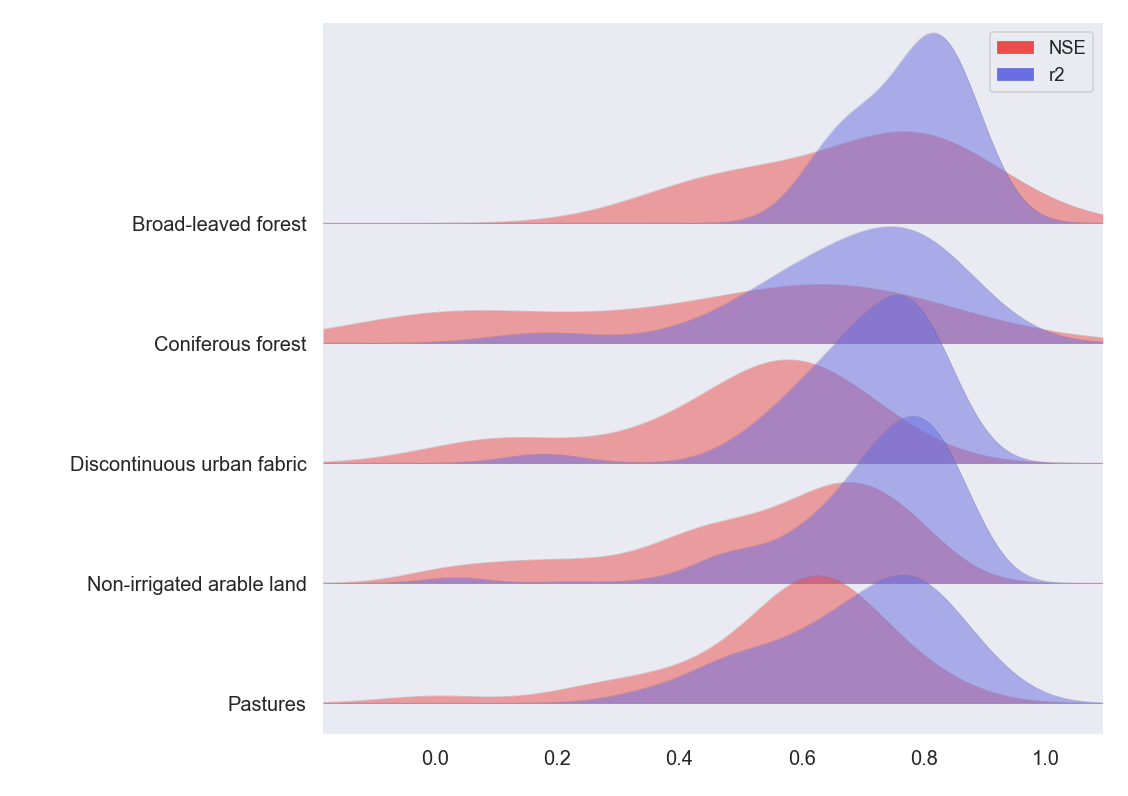

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [198]:
col='name'
joyplot(
    data=clcsint_sort1[['NSE','r2', col]], 
    by=col,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

### Multi-Order Hydrologic Position

J:\NUTZER\Noelscher.M\Studierende\Daten\multiorder_hydrologic_position\germany\time_invariant\raster\v013_1_1\data

### Distance to the sea, big water bodies and river

In [24]:
#Load the coastline of Lower Saxony
coastline=gpd.read_file("D:/Data/students/mariana/data/SHP/coastline.shp")
coastlines=coastline.to_crs(epsg=proj_coor)


In [63]:
#points=Point(coastlines.geometry[0].coords[0])
l=[]
for i in waterways.geometry[0].coords:
    l.append(Point(i))
gdf=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l)
gdf.plot()

In [99]:
gw_selc=gw_sel.copy()

In [124]:
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdf.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_coastkm']=vdist  

<IPython.core.display.Javascript object>


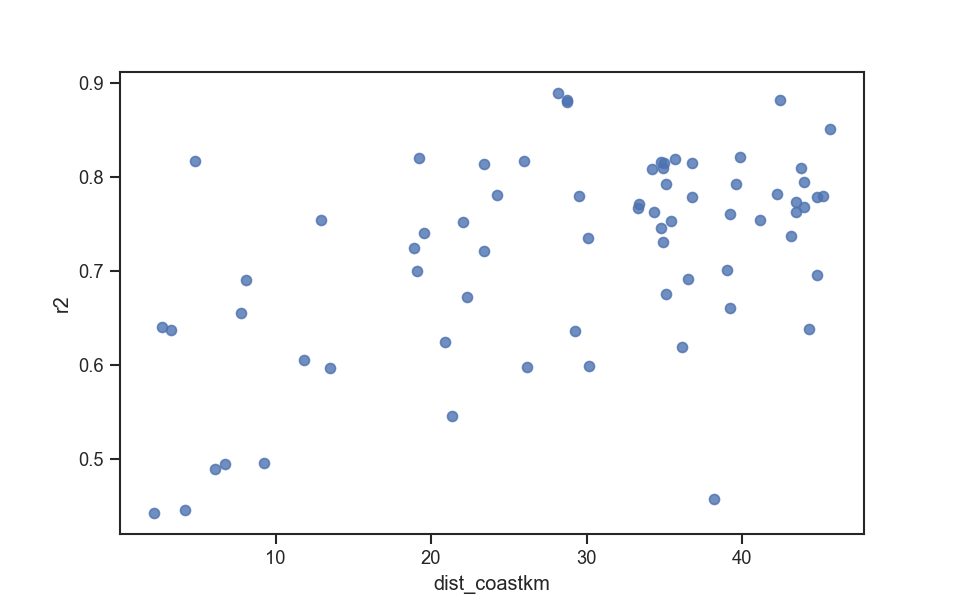

In [195]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x="dist_coastkm", y="r2", data=gw_sel.sort_values(by="dist_coastkm")[:150], fit_reg=False)

##### Waterways

In [147]:

waterways.geometry[50].coords[:4]

[(32385923.350410733, 5863264.9962101625),
 (32385883.850257903, 5863324.890270543),
 (32385658.168666724, 5863298.477734954),
 (32385606.341138538, 5863317.845253074)]

In [150]:
#points=Point(coastlines.geometry[0].coords[0])
l2=[]
for j in range(len(waterways.geometry)):
    if waterways.type[j] =='MultiLineString':
        lenmline=len(waterways.geometry[j])
        for ln in waterways.geometry[j]:
            lenline=len(ln)
            for i in range(lenline):
                l2.append(Point(waterways.geometry[j][i].coords[i]))
        
    for i in range(len(waterways.geometry[j].coords)):
        
            [l2.append(Point(waterways.geometry[j][i].coords[i]))]
        
        l2.append(Point(waterways.geometry[j].coords[i]))
#gdf2=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l2)
#gdf2.plot()


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [176]:
waterways.geometry[j][0].coords

[(32550927.943612877, 5934515.742228153),
 (32545292.697123103, 5935563.115640915)]

In [179]:
j

16

In [192]:
len(waterways.geometry[16])

2

In [189]:
len(waterways.geometry[16][0].coords)

18

In [188]:
waterways.type[15:20]


15         LineString
16    MultiLineString
17    MultiLineString
18    MultiLineString
19    MultiLineString
dtype: object

In [175]:
waterways.type[18]

'MultiLineString'

## Impervious layer 

Check how much the model performance is affected by the imperviousness density (%)

https://land.copernicus.eu/pan-european/high-resolution-layers/imperviousness/status-maps/2006?tab=mapview


### Geomorphology

Geomorphography from the Bundesanstalt für Geowissenschaften und Rohstoffe (BGR)

<IPython.core.display.Javascript object>


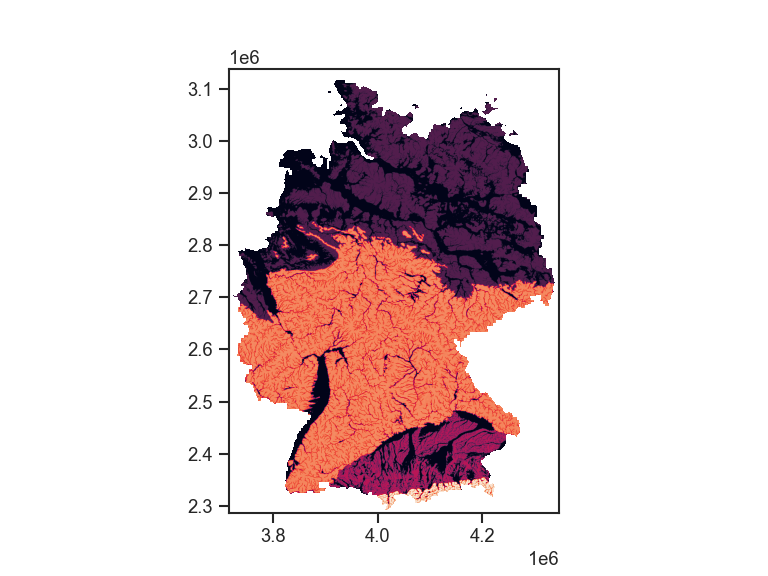

<AxesSubplot:>

In [223]:
sns.set_theme(style="ticks")
geomorphology=rasterio.open("D:/Data/students/mariana/data/Raster/geomorphography/gmk1000_250.tif")
#geomorphology.plot()
show(geomorphology)
#print(geomorphology.crs)
#geomorp=geomorphology.to_crs(epsg=proj_coor)

In [225]:
geomorphology.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LCC Europe",GEOGCS["ETRS89",DATUM["IRENET95",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",52],PARAMETER["central_meridian",10],PARAMETER["standard_parallel_1",35],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",4000000],PARAMETER["false_northing",2800000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

### Intersection with long-term recharge